# 12 - Credit Card Fraud Detection

In [1]:
'Main'
import numpy as np
import pandas as pd
'Data Viz'
import matplotlib.pyplot as plt

We will use a dataset of anonymized credit card transactions made by European cardholders from September 2013.

In [2]:
'''load dataset'''
data = pd.read_csv('https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The transactions are labeled as fraudulent (class = 1) or genuine (class = 0). 
The dataset is highly imbalanced. 
Of the 284.807 transactions, only 492 are fraudulent.

In [16]:
print('The percentage of fraudulent transactions is '+str(np.round(100*np.sum(data.Class==1)/len(data),3))+'%')

The percentage of fraudulent transactions is 0.173%


There are 30 features

In [19]:
data.columns[:-1]

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

The features v1--v28 are not the original features. The original features were distilled to 28 principal components using PCA.

## Anomaly Score Function

In [3]:
'''Create the feature matrix X and the labels array Y'''
X = data.drop(['Class'],axis=1).to_numpy() # feature matrix
y = data['Class'].to_numpy() # label vector

We will use the anomaly score function based on PCA

In [4]:
def anomalyScore_PCA(X,k):
    'scale the dataset'
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    X_scaled = (X-means)/stds
    'compute the singular value decomposition'
    _,_,v = np.linalg.svd(X_scaled,full_matrices=False) # singular value decomposition
    'reconstruct X_scaled based on the first k principal components'
    X_reconstructed = (X_scaled@v[:k].T)@v[:k]
    'compute anomaly scores'
    scores = np.linalg.norm(X_scaled-X_reconstructed,axis=1)
    scores = (scores-np.min(scores))/(np.max(scores)-np.min(scores))
    return scores

In [43]:
k = 10 # number of principal components
scores = anomalyScore_PCA(X,k)

In [44]:
scores

array([0.00855575, 0.00759626, 0.0288848 , ..., 0.01575277, 0.02636083,
       0.01160075])

Next, we need to map the scores to class labels.
This is achieved by using a threshold, such as 0.5, where all values equal or greater than the threshold are mapped to one class (fraudulent class) and all other values are mapped to another class (genuine class).

In [53]:
threshold = 0.5
prediction = np.zeros(len(scores))
prediction[scores>=threshold] = 1 
prediction

array([0., 0., 0., ..., 0., 0., 0.])

The problem is that the default threshold may not represent an optimal interpretation of the predicted scores.

## Precision-Recall Trade-off

For imbalanced datasets, a good way to find a good threshold value is to use the **precision-recall** curve.

**Precision** and **recall** are defined as

$$
\mbox{precision} = \frac{\mbox{TP}}{\mbox{TP}+\mbox{FP}} \qquad \mbox{and} \qquad
\mbox{recall} = \frac{\mbox{TP}}{\mbox{TP}+\mbox{FN}},
$$

where

   1. TP is the number of true positives,
   2. FP is the number of false positives, and
   3. FN is the number of false negatives.

A high precision means that the model has a low false positive rate. A high recall means that the model has a low false negative rate.
An optimal solution needs to have high precision and high recall.

We can try different thresholds and plot precision against recall:

In [5]:
'Precision-Recall Curve'
threshold_list  = np.linspace(0.01,.99,100) 
precision = np.zeros(100)
recall = np.zeros(100)
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall[i] = TP/(TP+FN)
    precision[i] = TP/(TP+FP)
    i = i+1

NameError: name 'scores' is not defined

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(recall,precision,'bo-')
plt.suptitle('Precision vs Recall Curve',fontsize=20)
plt.title('Average Precision='+str(np.round(np.mean(precision),3)))
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)

With an average precision of 0.061, this is a poor fraud detection method. 
It catches very little of the fraud.

## Search for the Optimal Number of Principal Components

After some experimentation, I found that k = 27 principal components is the optimal number for this credit card transactions dataset.

Text(0, 0.5, 'Precision')

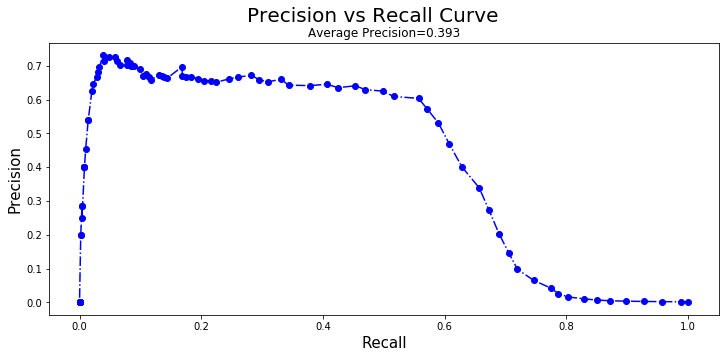

In [75]:
'compute anomaly scores'
k = 27 # number of principal components
scores = anomalyScore_PCA(X,k)
'compute precision and recall for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
precision = np.zeros(100)
recall = np.zeros(100)
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall[i] = TP/(TP+FN)
    precision[i] = TP/(TP+FP)
    i = i+1
'Plot Precision vs Recall Curve'
plt.figure(figsize=(12,5))
plt.plot(recall,precision,'bo-.')
plt.suptitle('Precision vs Recall Curve',fontsize=20)
plt.title('Average Precision='+str(np.round(np.mean(precision),3)))
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)

We can see that precision really starts to fall sharply around 60% recall. 
We probably want to select a precision/recall trade-off just before that drop.

## The $F_1$-score

The $F_1$-score is another common tool used to find a good threshold value.
The $F_1$-score is the *harmonic mean* of precision and recall

$$
F_1 = \frac{2}{\frac{1}{\mbox{precision}}+\frac{1}{\mbox{recall}}}
$$

The $F_1$ score is high if both recall and precision are high.

Text(0, 0.5, 'F1-score')

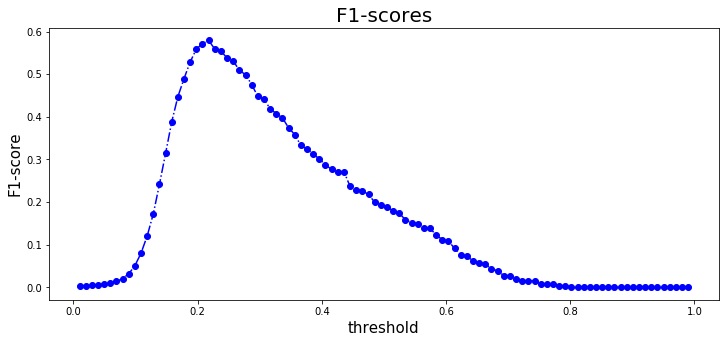

In [78]:
'compute anomaly scores'
k = 27 # number of principal components
scores = anomalyScore_PCA(X,k)
'compute F1-score for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
F1_score = np.zeros(100) 
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    if precision*recall!=0:
        F1_score[i] = 2*(precision*recall)/(precision+recall)
    else:
        F1_score[i]=0 # the harmonic mean is undefined if both precision and recall are zero
    i = i+1
'Plot F1-score agains threshold'
plt.figure(figsize=(12,5))
plt.plot(threshold_list,F1_score,'bo-.')
plt.title('F1-scores',fontsize=20)
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)

The best threshold value is:

In [79]:
threshold_list[np.argmax(F1_score)]

0.21787878787878787